In [29]:
import torch
from torch import nn
from torch.utils.data import Dataset, dataloader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used : {device}")

from src.ColorNN import UpscaleResidualNN as ColorNN

device used : cuda


In [30]:
class CustomFlowersDataset(Dataset):
	def __init__(self, root, split="train", transform=None, download=False):
		self.flowers_dataset = Flowers102(root=root, split=split, download=download)
		self.transform = transform

	def __getitem__(self, index):
		image, _ = self.flowers_dataset[index]
		if self.transform is not None:
			image = self.transform(image)
		return image[0:1,...], image

	def __len__(self):
		return len(self.flowers_dataset)


In [31]:
root_dir = "./ressources"

transform = v2.Compose([
	color.rgb2lab,
	v2.ToImage(),
	v2.ToDtype(torch.float32),
	v2.Resize((200,200), antialias=True),
	v2.Normalize(((0.,0.,50.)), ((127.,127.,50.)))
])

def UnNormalize(img):
	return v2.Compose([
		v2.Normalize((0.,0.,0.), (1/127.,1/127.,1/50.)),
		v2.Normalize((0.,0.,-50.), (1.,1.,1.))
	])(img)

train_dataset = CustomFlowersDataset(root=root_dir, split="test", transform=transform, download=True)
test_dataset = CustomFlowersDataset(root=root_dir, split="train", transform=transform, download=True)

Train dataset size: 6149
Test dataset size: 1020
Images shapes :torch.Size([1, 200, 200]) (input), torch.Size([3, 200, 200]) (target)


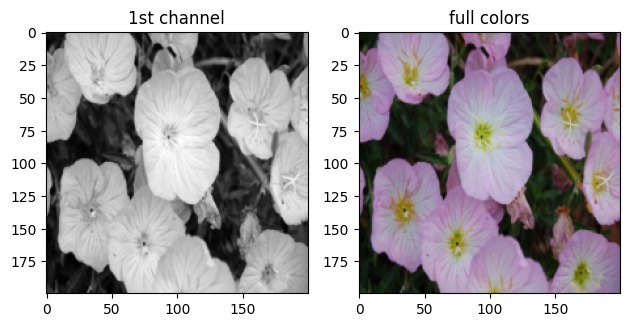

In [33]:
def tensorToImg(tensor:torch.Tensor):
	return tensor.moveaxis(0,2).detach().cpu().numpy()

print("Train dataset size:",len(train_dataset))
print("Test dataset size:",len(test_dataset))
img2 = test_dataset[0][1]
img1 = img2[0:1,...]
img2 = UnNormalize(img2)
print(f"Images shapes :{img1.shape} (input), {img2.shape} (target)")
fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(tensorToImg(img1), cmap="grey")
ax1.set_title("1st channel")
ax2.imshow(color.lab2rgb(tensorToImg(img2)))
ax2.set_title("full colors")
plt.tight_layout()

In [20]:
img = train_dataset[0][1]
img2 = UnNormalize(img)
print(img.shape)
print(max(img[0][0]),max(img[0][1]),max(img[0][2]))
print(min(img[0][0]),min(img[0][1]),min(img[0][2]))
print(img2.shape)
print(max(img2[0][0]),max(img2[0][1]),max(img2[0][2]))
print(min(img2[0][0]),min(img2[0][1]),min(img2[0][2]))

torch.Size([3, 200, 200])
tensor(0.4256) tensor(0.4132) tensor(0.3988)
tensor(0.0646) tensor(0.0810) tensor(0.0890)
torch.Size([3, 200, 200])
tensor(54.0525) tensor(52.4786) tensor(50.6451)
tensor(8.2033) tensor(10.2916) tensor(11.3067)


In [6]:
import numpy as np

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
	model = model.to(device)
	# size = len(dataloader.dataset)

	model.train()

	tot_loss = 0.
	
	for batch, (X, y) in enumerate(dataloader):
		# torch.cuda.empty_cache()
		# Compute prediction and loss
		if len(X.shape) == 3:
			X = X.unsqueeze(0)
		if len(y.shape) == 3:
			y = y.unsqueeze(0)
		X = X.to(device)
		y = y.to(device)
		pred = model(X)
		loss = loss_fn(pred, y)
		tot_loss += loss.item()

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if verbose:
			loss, current = loss.item(), (batch + 1) * len(X)
			print(f"loss: {loss:>7f}  [{current:>5d}/{1:>5d}]")
	
	return tot_loss


# img print
def print_imgs(model, dataset):
	fig = plt.figure()
	axes = fig.subplots(3, 3)
	for ax1,ax2,ax3 in axes:
		i = np.random.randint(len(dataset))
		img1, img2 = dataset[i]
		out = model(img1.unsqueeze(1).to(device))
		ax1.imshow(img1.moveaxis(0, 2), cmap="grey")
		ax2.imshow(color.lab2rgb(UnNormalize(out.squeeze(0).detach().moveaxis(0, 2).cpu()))
		ax3.imshow(color.lab2rgb(img2.moveaxis(0, 2).cpu()))

	plt.tight_layout()

### Overfit test

In [7]:
import tqdm

model = ColorNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

imgs = [train_dataset[i] for i in range(10)]
loss_per_epoch = []
for t in tqdm.tqdm(range(1000)):
    loss_per_epoch.append(train_loop(imgs, model, criterion, optimizer, verbose=False))
print("\nDone!")


100%|██████████| 1000/1000 [01:02<00:00, 15.94it/s]


Done!


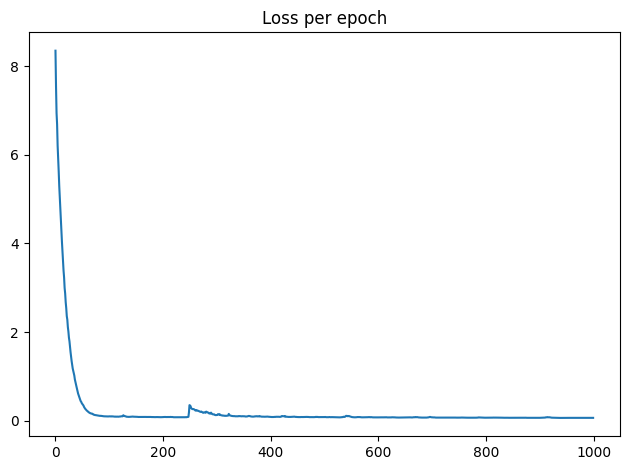

In [8]:
plt.plot(loss_per_epoch)
plt.title("Loss per epoch")
plt.tight_layout()

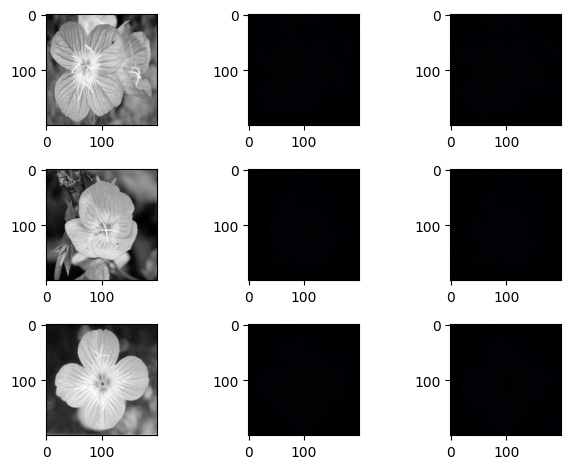

In [9]:
print_imgs(model, imgs)

### Main test

In [10]:
# Define the model
model = ColorNN()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Dataloaders
train_loader = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = dataloader.DataLoader(test_dataset, shuffle=True, batch_size=32)

# Set the number of epochs
num_epochs = 10

loss_per_epoch = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_per_epoch.append(train_loop(train_loader, model, criterion, optimizer))
print("Done!")

Epoch 1
-------------------------------
loss: 0.907076  [   32/    1]
loss: 0.887938  [   64/    1]
loss: 0.865172  [   96/    1]
loss: 0.821118  [  128/    1]
loss: 0.816990  [  160/    1]
loss: 0.787345  [  192/    1]


KeyboardInterrupt: 

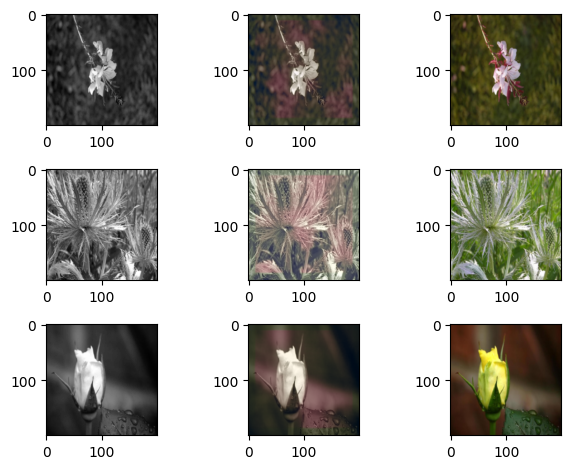

In [ ]:
print_imgs(model, train_dataset)